In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import random 
random.seed(42)
import os
import cv2
from sklearn.metrics import classification_report, f1_score, make_scorer
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import tensorflow
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
import tensorflow.keras.backend as K

### Data Preprocessing ###
The facenet model requires images 160x160x3, will be resizing our images and converting to greyscale
Using Siamese network requires the data to be processed for binary classification:every sample contains two images with corresponding binary target.
Where matched(with target of 1) and unmatched(with target of 0) pairs will be created.



In [2]:
# Get the data directory paths
face_images = np.load('../input/olivetti/olivetti_faces.npy')
face_labels = np.load('../input/olivetti/olivetti_faces_target.npy')

In [3]:
images = []

for image in face_images:
    img= cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    img=cv2.resize(img, (160,160),interpolation = cv2.INTER_AREA)
    
    images.append(img)
    
labels = face_labels

In [4]:
# viewing how many images belong to each subject

unique_labels = np.unique(labels)

image_dataset=[]
for label in range(len(unique_labels)):
    subject=[]
    for u in range(len(labels)):
        if labels[u]==label:
            
            subject.append(images[u])
    print(str(len(subject))+" images belonging to face "+ str(label))

10 images belonging to face 0
10 images belonging to face 1
10 images belonging to face 2
10 images belonging to face 3
10 images belonging to face 4
10 images belonging to face 5
10 images belonging to face 6
10 images belonging to face 7
10 images belonging to face 8
10 images belonging to face 9
10 images belonging to face 10
10 images belonging to face 11
10 images belonging to face 12
10 images belonging to face 13
10 images belonging to face 14
10 images belonging to face 15
10 images belonging to face 16
10 images belonging to face 17
10 images belonging to face 18
10 images belonging to face 19
10 images belonging to face 20
10 images belonging to face 21
10 images belonging to face 22
10 images belonging to face 23
10 images belonging to face 24
10 images belonging to face 25
10 images belonging to face 26
10 images belonging to face 27
10 images belonging to face 28
10 images belonging to face 29
10 images belonging to face 30
10 images belonging to face 31
10 images belongin

### Generating pairs ###

In [5]:
pair_img1 = []
pair_img2 = []
pair_label = []
image_dataset = []


# neg pairs
for ind, image2 in enumerate(images):
    neg_indices = list(range(1,ind)) + list(range(ind+1,11))
    neg_image = images[np.random.choice(neg_indices)]
    pair_img1.append(image2)
    pair_img2.append(neg_image)
    pair_label.append(1)
    image_dataset.append((pair_img1, pair_img2))

            
# positive pairs            
for ind, image in enumerate(images):
    for label in range(len(labels)):
        if labels[ind] == labels[label]:
            if ind == label:
                pass
            else:
                pair_img1.append(image)
                pair_img2.append(images[label])
                pair_label.append(0)
                
                image_dataset.append((pair_img1, pair_img2))

In [6]:
len(image_dataset)

4000

In [7]:
c = list(zip(pair_img1, pair_img2, pair_label))

random.shuffle(c)

a, b, y = zip(*c)

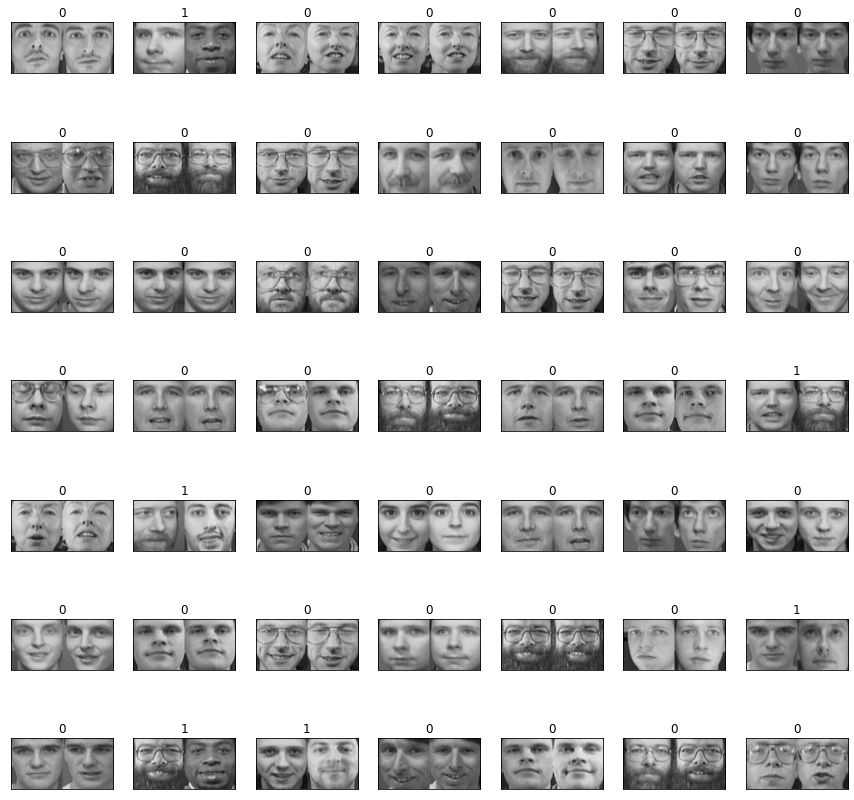

In [8]:
fig=plt.figure(figsize=(15, 15))
columns = 7
rows = 7
for i in range(1, columns*rows +1):
    ax=fig.add_subplot(rows, columns, i)
    
    plt.imshow(np.concatenate([a[i-1],b[i-1]], axis=1))
    ax.title.set_text(y[i-1])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

### Training : Using Facenet Model ###

In [9]:
# initializing the facenet model

base_model = models.load_model('../input/facenet-model/facenet_keras.h5')
base_model.load_weights("../input/facenet-model/facenet_keras_weights.h5")
base_model.trainable=False

2022-08-16 12:39:04.158263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 12:39:04.250793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 12:39:04.251648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 12:39:04.254072: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
# Distance Layer
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [11]:
# embedd the distance layer

features=Model(base_model.input, base_model.output)

anchor_input =Input((160,160,3))
compare_input =Input((160,160,3))

distances = DistanceLayer()(
    features(anchor_input),
    features(compare_input),
)

In [12]:
x= Dense(96, activation="relu")(distances)
x= Dropout(0.3)(x)
x= Dense(64)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=[anchor_input,compare_input],outputs=outputs)

In [13]:
model.compile(loss='binary_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          22808144    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
distance_layer (DistanceLayer)  (None, 1)            0           model[0][0]                

In [14]:
history=model.fit([np.array(a)[:], np.array(b)[:]],np.array(y)[:],validation_split=0.2, epochs=10, batch_size=16)

2022-08-16 12:39:14.590067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-08-16 12:39:15.663084: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-08-16 12:39:16.753066: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-08-16 12:39:17.543662: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 983040000 exceeds 10% of free system memory.
2022-08-16 12:39:18.366963: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-16 12:39:28.408439: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 34s 89ms/step - loss: 0.3097 - accuracy: 0.9072 - val_loss: 0.1505 - val_accuracy: 0.9450
Epoch 2/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1742 - accuracy: 0.9347 - val_loss: 0.1760 - val_accuracy: 0.9200
Epoch 3/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1691 - accuracy: 0.9316 - val_loss: 0.1433 - val_accuracy: 0.9413
Epoch 4/10
200/200 [==============================] - 14s 68ms/step - loss: 0.1728 - accuracy: 0.9347 - val_loss: 0.1448 - val_accuracy: 0.9513
Epoch 5/10
200/200 [==============================] - 14s 70ms/step - loss: 0.1610 - accuracy: 0.9378 - val_loss: 0.1439 - val_accuracy: 0.9488
Epoch 6/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1680 - accuracy: 0.9356 - val_loss: 0.1400 - val_accuracy: 0.9425
Epoch 7/10
200/200 [==============================] - 14s 69ms/step - loss: 0.1689 - accuracy: 0.9362 - val_loss: 0.1439 - val_accuracy: 0.9500
Epo

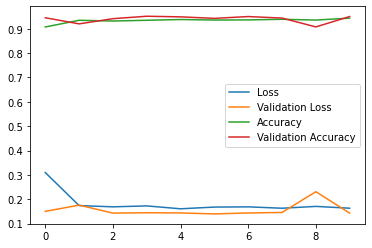

In [15]:
# Training Plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])